# Sentiment Analysis of Google Play Store User Reviews 

In [18]:
!pip install google-play-scraper
!pip install wordcloud
!pip install textblob
!pip install emoji
!pip install pandas_profiling
!pip install seaborn
!pip install csv

ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv


In [19]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import string
import emoji
import re
import warnings
import seaborn as sns
%matplotlib inline

warnings.filterwarnings("ignore")

In [20]:
# Global Variables 
appStore = "Android"
lang = "en"
country = "us"
appId = "651293599" #For Apple 
appName =  "bd" #"mySugr" #"accuChek" #"OneTouchReveal" # 
playStoreAppName=   "com.bd.dh.briight" #"com.ibx.ibxmobile" #"dh.briight"# "com.mysugr.android.companion" #"com.roche.Accu_Chek_C_US" #"com.lifescan.reveal"# 
appAnalysisFolderPath = "appAnalysis/{0}/{1}".format(appName,appStore)

In [21]:
# Folder Creation
import os

def createFolderIfNotExists(folderPath):
    if not os.path.exists(folderPath):
        print(folderPath)
        os.makedirs(folderPath)

In [6]:
# Create Output Folders
createFolderIfNotExists(appAnalysisFolderPath)
createFolderIfNotExists("{0}/data".format(appAnalysisFolderPath))
createFolderIfNotExists("{0}/result".format(appAnalysisFolderPath))
createFolderIfNotExists("{0}/result/wordCloud".format(appAnalysisFolderPath))
createFolderIfNotExists("{0}/profilerResults".format(appAnalysisFolderPath))

## 1. Data Collection

### 1.1 Extract User Reviews

In [28]:
def extractUserReviews(appStore, appId):

    if (appStore == "Android"):
        from google_play_scraper import app, Sort, reviews_all
        
        app_Details = app(playStoreAppName)#, lang='fr', country='fr')
        
        #, continuation_token
        app_Reviews = reviews_all(
            playStoreAppName,
            lang='fr', # defaults to 'en'
            country='fr', # defaults to 'us'
            sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
        )
    else:
        from app_store_scraper import AppStore

        app_Reviews = AppStore(
            country='us', 
            app_name=playStoreAppName,
            app_id = appId)
        app_Reviews.review(how_many=1000000)

    return app_Reviews, app_Details

In [29]:
app_Reviews, app_Details = extractUserReviews(appStore,appId)
app_Details

{'title': 'BD™ Diabetes Care',
 'description': '<b>** BD, the company that, helps 30 million people with diabetes each year! **</b>\r\n\r\nBD™ Diabetes Care (BDDC) is the smarter, simpler approach to diabetes management for people who have Type 1 or Type 2 diabetes.\r\n\r\nDownload today and get a personal diabetes assistant, Briight, at the push of a button available 24/7; a diabetes log; access to a range of healthy diabetic recipes; tools to help you maintain a normal blood sugar level and much more!\r\n\r\n<b>GET ADVICE & KNOWLEDGE TO ENJOY THE THINGS YOU LOVE!</b>\r\nKeep a diabetic log book to receive actionable insights, save your favorite healthy snacks and get personalized nutritional advice for diabetic diet plans. Help manage your blood sugar levels and learn how to fit some of your favorite meals into your diet plan with a range of diabetic recipes. BD™ Diabetes Care has you covered with instant answers to all your food questions when you need them most.\r\n\r\n<b>Why manag

In [27]:
pd.DataFrame(np.array(app_Reviews),columns=['review'])

,review
0,{'reviewId': '5f2e23ca-b15c-4f2c-aaac-854834ea...


In [10]:
df = pd.DataFrame(np.array(app_Reviews),columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))

In [10]:
df_app = df
# Drop index column and Extract df into a csv file
reviewsOutputFilePath = "{0}/data/{1}-PlayStore_Reviews.csv".format(appAnalysisFolderPath, appName)
df_app.to_csv(reviewsOutputFilePath, index=False)

df_app.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,d154db5e-e5e6-4b24-a87c-4244404ca924,Ginny Alfman,https://play-lh.googleusercontent.com/a-/ACNPE...,"I like this app, except for the two times it o...",2,0,3.4.0-170,2022-10-01 12:37:39,"Thank you for reaching out, Ginny. Please reac...",2022-10-02 14:09:56
1,54ef3462-dead-466d-a461-47fdb92d1db8,Bruce Franz,https://play-lh.googleusercontent.com/a/ALm5wu...,All sorts of fancy-pants stuff but can't make ...,1,1,3.3.0,2022-06-18 11:23:14,Hi Bruce - I'm sorry to hear that you are unha...,2022-06-20 01:13:55


## 2. Exploratory Data Analysis (EDA) 

### 2.1 User Scores Visualization

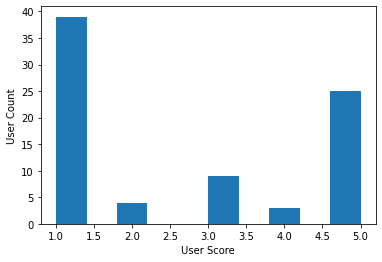

In [11]:
plt.hist(df_app["score"])#, bins=1, rwidth=0.9, color='#607c8e')    
plt.xlabel("User Score")
plt.ylabel("User Count")

#figHist, ax = plt.subplots(figsize = (6,4))

reviewsHistogramFilePath = "{0}/result/{1}-reviewsHistogram.jpg".format(appAnalysisFolderPath, appName)

# Save the histogram
plt.savefig(reviewsHistogramFilePath)

# Display the plot
plt.show()

### 2.2 Profile Input Data

In [12]:
edaProfileFilePath = "{0}/profilerResults/{1}-eda-profile.html".format(appAnalysisFolderPath, appName)

from pandas_profiling import ProfileReport

ProfileReport(df_app).to_file(output_file=edaProfileFilePath)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Sentiment Analysis of Reviews 

In [13]:
df=df[["reviewCreatedVersion","score","content","thumbsUpCount"]]
df

,reviewCreatedVersion,score,content,thumbsUpCount
0,3.4.0-170,2,"I like this app, except for the two times it o...",0
1,3.3.0,1,All sorts of fancy-pants stuff but can't make ...,1
2,3.3.0,2,Do you connect this to your free style sensor,0
3,3.3.0,1,"Downloaded twice, nothing showed up, no app, n...",1
4,None,1,Tried to set up an account but it doesn't work...,0
...,...,...,...,...
75,1.1.6,5,Great app,13
76,1.1.1,3,I wish it would allow me to track other vital ...,25
77,1.1.1,5,Great articles,13
78,1.0.0,5,I like the healthy recipes,11


In [14]:
check_total_none=df.isnull().sum()
print(check_total_none)

reviewCreatedVersion    34
score                    0
content                  0
thumbsUpCount            0
dtype: int64


In [15]:
df['content'] = df['content'].astype(str)
df['content']

0     I like this app, except for the two times it o...
1     All sorts of fancy-pants stuff but can't make ...
2         Do you connect this to your free style sensor
3     Downloaded twice, nothing showed up, no app, n...
4     Tried to set up an account but it doesn't work...
                            ...                        
75                                            Great app
76    I wish it would allow me to track other vital ...
77                                       Great articles
78                           I like the healthy recipes
79                  Very smart and gives quick answers.
Name: content, Length: 80, dtype: object

In [16]:
def senti_polarity(x):
    if x is not None:
       return TextBlob(x).sentiment.polarity

def senti_subjectivity(x):
    if x is not None:
       return TextBlob(x).sentiment.subjectivity

def getAnalysis(score):
    #threshold was increased, to consider more negative reviews
    if score < 0.25:
        return 'Negative'
    # elif score == 0:
    #     return 'Neutral'
    else:
        return 'Positive'
    
#Create two new columns ‘Subjectivity’ & ‘Polarity’
df['sentiment_polarity'] = df['content'].apply(senti_polarity)
df['sentiment_subjectivity'] = df['content'].apply(senti_subjectivity)
df['sentiment_analysis'] = df['sentiment_polarity'].apply(getAnalysis)

df

,reviewCreatedVersion,score,content,thumbsUpCount,sentiment_polarity,sentiment_subjectivity,sentiment_analysis
0,3.4.0-170,2,"I like this app, except for the two times it o...",0,-0.266667,0.655556,Negative
1,3.3.0,1,All sorts of fancy-pants stuff but can't make ...,1,0.500000,0.625000,Positive
2,3.3.0,2,Do you connect this to your free style sensor,0,0.400000,0.800000,Positive
3,3.3.0,1,"Downloaded twice, nothing showed up, no app, n...",1,-0.200000,0.000000,Negative
4,None,1,Tried to set up an account but it doesn't work...,0,-0.500000,0.900000,Negative
...,...,...,...,...,...,...,...
75,1.1.6,5,Great app,13,0.800000,0.750000,Positive
76,1.1.1,3,I wish it would allow me to track other vital ...,25,0.195000,0.555000,Negative
77,1.1.1,5,Great articles,13,0.800000,0.750000,Positive
78,1.0.0,5,I like the healthy recipes,11,0.500000,0.500000,Positive


In [17]:
reviewsAnalysisFilePath = "{0}/result/{1}-PlayStore-SentimentAnalysis.csv".format(appAnalysisFolderPath,appName)
df.to_csv(reviewsAnalysisFilePath, index=False)

## 4. Insights

In [18]:
#Negative reviews
df_neg = df[df['sentiment_analysis'] == 'Negative']

In [19]:
#Positive reviews
df_pos = df[df['sentiment_analysis'] == 'Positive']

### 4.1 Graphs - Visualize the output

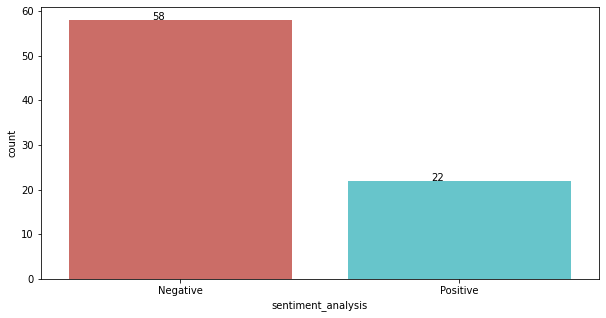

In [20]:
# Count Plot for Sentiment analysis

plt.figure(figsize=(10, 5))
b1 = sns.countplot(x="sentiment_analysis", data=df, palette="hls")

for p in b1.patches:
    b1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.01))

reviewsComparisonGraphFilePath = "{0}/result/{1}-ReviewsComparisonGraph.jpg".format(appAnalysisFolderPath, appName)

plt.savefig(reviewsComparisonGraphFilePath, dpi=100, bbox_inches='tight')
plt.show()

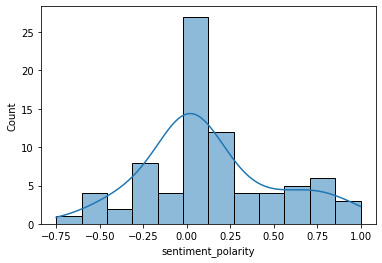

In [21]:
# Count Plot for Sentiment polarity
sns.histplot(data = df['sentiment_polarity'], kde = True)

sentimentsPolarityGraphFilePath = "{0}/result/{1}-SentimentsPolarityGraph.jpg".format(appAnalysisFolderPath, appName)
plt.savefig(sentimentsPolarityGraphFilePath, dpi=100, bbox_inches='tight')

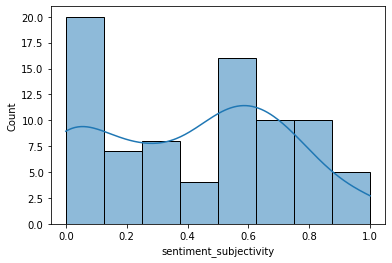

In [22]:
# Count Plot for Sentiment subjectivity
sns.histplot(data = df['sentiment_subjectivity'], kde = True)

sentimentsSubjectivityGraphFilePath = "{0}/result/{1}-SentimentsSubjectivityGraph.jpg".format(appAnalysisFolderPath, appName)
plt.savefig(sentimentsSubjectivityGraphFilePath, dpi=100, bbox_inches='tight')

### 4.2 Word Cloud - Commonly occuring words

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, polarity, title = None):
    text = data.tolist()
    text = ' '.join(text).lower()
    
    stop_words = ["app", "mobile", "phone", "love", "good", "great"] + list(STOPWORDS)
    
    wordcloud = WordCloud(
        stopwords = stop_words,
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(text)

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    rel_count = wordcloud.words_
    word_count = wordcloud.process_text(text)
    
    wordCloudFilePath = "{0}/result/wordCloud/{1}-wordCloud-{2}.png".format(appAnalysisFolderPath, appName, polarity)
    wordcloud.to_file(wordCloudFilePath)
    
    plt.imshow(wordcloud)
    plt.show()
    return rel_count, word_count 

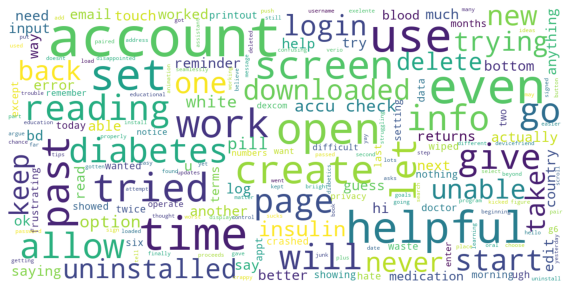

In [24]:
n_rel, n_word = show_wordcloud(df_neg["content"], "negative")

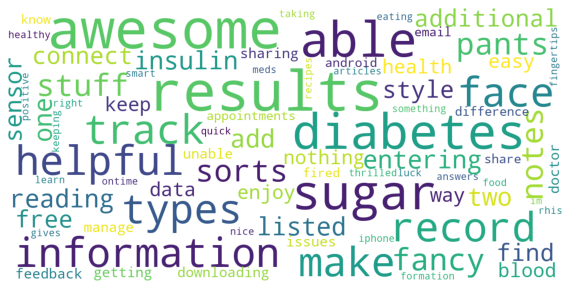

In [25]:
# print wordcloud
p_rel, p_word = show_wordcloud(df_pos["content"], "positive")

### 4.3 Word Count - Frequency and Polarity of words 

In [26]:
# concat values from 2 dictionaries, if same keys
def merge_dict(d1, d2):
    ds = [d1, d2]
    d = {}
    for k in d1.keys():
      d[k] = tuple(d[k] for d in ds)
        
    return d

In [27]:
import csv

def saveDictionaryFile(d, filePath):
    field_names = ['Word','Percentage','Occurence']
       
    with open(filePath, "w") as f:
        csv.writer(f).writerow(field_names)
        csv.writer(f).writerows((k,) + v for k, v in d.items())

In [28]:
wordCountDictNegative = merge_dict(n_rel, n_word)
wordCountFilePath = "{0}/result/{1}-WordCountNegative.csv".format(appAnalysisFolderPath,appName)

saveDictionaryFile(wordCountDictNegative, wordCountFilePath)

In [29]:
wordCountDictPositive = merge_dict(p_rel,p_word)
wordCountFilePath = "{0}/result/{1}-WordCountPositive.csv".format(appAnalysisFolderPath,appName)

saveDictionaryFile(wordCountDictPositive, wordCountFilePath)

### 4.4 Key Filter Factors

#### 4.4.1 Mean rating for word

In [30]:
# define empty dataframe to store matrix
def rating_df():
    return pd.DataFrame(columns=[1,2,3,4,5])

def score_and_keyword_occurence_matrix(source_df, keyword, matrix_df): 
    # '(?i)' to ignore casing using regex
    word_score_count = np.array(source_df[source_df['content'
                            ].str.contains('(?i)'
                            + keyword)].groupby('score')['score'
                            ].count() / source_df[source_df['content'
                            ].str.contains('(?i)' + keyword)]['score'
                            ].count() * 100)

    if len(word_score_count) < 5:
        c = [0.0] * (5-len(word_score_count))
        kw = word_score_count.tolist()
        kw.extend(c)
        matrix_df.loc[keyword] = np.array(kw)    
    else:
        matrix_df.loc[keyword] = word_score_count
        
    return matrix_df        

In [31]:
def buildScoreRelevanceForTopKeyWords(source_df, wordCountDictionary, matrix_df, count=5):
    iterationCount = 0
    
    for k,v in wordCountDictionary.items():
        iterationCount = iterationCount + 1
        # This part of the code can be written in a better manner, taking the easy route for now 
        if (iterationCount <= count): 
            score_and_keyword_occurence_matrix(source_df, k, matrix_df)
        else:
            break
    return 

In [32]:
def getTopCommentsForTopKeyWords(source_df, wordCountDictionary, negativeComments = True, keywordLimit=5, count=10):
    iterationCount = 0
        
    dfComments = source_df.iloc[:0,:].copy()
    keywords = []
    
    for k,v in wordCountDictionary.items():
        iterationCount = iterationCount + 1
        # This part of the code can be written in a better manner, taking the easy route for now 
        if (iterationCount <= keywordLimit): 
            
            order = not negativeComments
            
            x = source_df[source_df['content'
                                  ].str.contains('(?i)'+k)].sort_values(by=['reviewCreatedVersion'
                                  , 'thumbsUpCount'], ascending = order).head(count)
            
            # Populate column for keywords                            
            for y in range(len(x)):
                keywords.append(k)
                
            dfComments = dfComments.append(x, ignore_index=True)
            
        else:
            break
    
    # Add Keyword column to the filtered dataframe        
    dfComments["Keyword"] = keywords
    return dfComments

#### 4.4.2 Relative %  of word for each score 

In [33]:
def plot_bar(matrix_df, filePath):
    df_bar = matrix_df.transpose()
    ycol = df_bar.columns.tolist()
    df_bar = df_bar.reset_index()
    
    # plotting graph
    print(df_bar)
    plot = df_bar.plot(x="index", y=ycol, kind="bar", figsize=(7, 5))
    
    fig = plot.get_figure()
    fig.savefig(filePath)    

   index    account  even       time        use        set
0      1  81.818182  75.0  83.333333  55.555556  71.428571
1      2   9.090909  25.0  16.666667  11.111111  28.571429
2      3   9.090909   0.0   0.000000  11.111111   0.000000
3      4   0.000000   0.0   0.000000  22.222222   0.000000
4      5   0.000000   0.0   0.000000   0.000000   0.000000


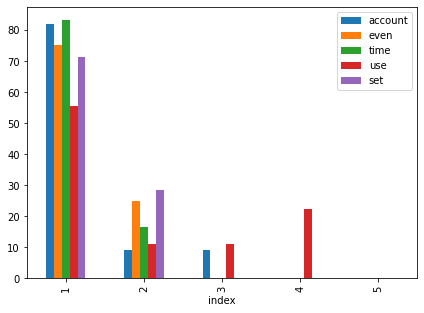

In [34]:
# negative reviews keywords: meter(app functional), bluetooth(connectivity), reading(tracking), meal(bedtime and meal time), privacy, update(version update issues)
matrix_df_neg = rating_df()
buildScoreRelevanceForTopKeyWords(df_neg, wordCountDictNegative, matrix_df_neg, 5)

wordRatingsComparisonFilePath = "{0}/result/{1}-WordsRatingsComparison-Negative.jpg".format(appAnalysisFolderPath, appName)
plot_bar(matrix_df_neg, wordRatingsComparisonFilePath)

   index  awesome  results      sugar       able  diabetes
0      1     25.0    100.0  33.333333  33.333333     100.0
1      2     75.0      0.0  66.666667  33.333333       0.0
2      3      0.0      0.0   0.000000  33.333333       0.0
3      4      0.0      0.0   0.000000   0.000000       0.0
4      5      0.0      0.0   0.000000   0.000000       0.0


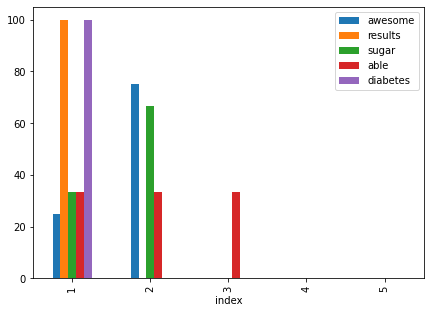

In [35]:
# positive reviews keywords: easy to use, great app, keep track, blood sugar 
matrix_df_pos = rating_df()
buildScoreRelevanceForTopKeyWords(df_pos, wordCountDictPositive, matrix_df_pos, 5)

wordRatingsComparisonFilePath = "{0}/result/{1}-WordsRatingsComparison-Positive.jpg".format(appAnalysisFolderPath, appName)
plot_bar(matrix_df_pos, wordRatingsComparisonFilePath)

### 4.5 Fetch the top relevant reviews (End Goal)

In [36]:
# Fetch Top Negative Comments
df_topNegativeComments = getTopCommentsForTopKeyWords(df_neg, wordCountDictNegative, True, 5, 10)

topNegativeReviewsOutputFilePath = "{0}/result/{1}-TopNegativeReviews.csv".format(appAnalysisFolderPath, appName)
df_topNegativeComments.to_csv(topNegativeReviewsOutputFilePath, index=False)

In [37]:
# Fetch Top Positive Comments
df_topPositiveComments = getTopCommentsForTopKeyWords(df_pos, wordCountDictPositive, False, 5, 10)

topPositiveReviewsOutputFilePath = "{0}/result/{1}-TopPositiveReviews.csv".format(appAnalysisFolderPath, appName)
df_topPositiveComments.to_csv(topPositiveReviewsOutputFilePath, index=False)